In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.steinhardt import *
from src.data import *
from src.plotting import *

plt.style.use('plot.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fausto_steinhardt, fausto_dens = process_water_structures('testing')
mda_steinhardt, mda_dens = process_mda_structures(all_runs=True)

In [4]:
all_faustos = np.vstack(list(fausto_steinhardt.values()))
all_mdas = np.vstack(list(mda_steinhardt.values()))

all_data = np.vstack((all_faustos, all_mdas))

In [5]:
fausto_av_steinhardt = {}
fausto_stds = {}
for struct_type, steinhardts in fausto_steinhardt.items():
    fausto_av_steinhardt[struct_type] = np.mean(steinhardts, axis=0)
    
mda_av_steinhardt = {}
mda_stds = {}
for struct_type, steinhardts in mda_steinhardt.items():
    mda_av_steinhardt[struct_type] = np.mean(steinhardts, axis=0)

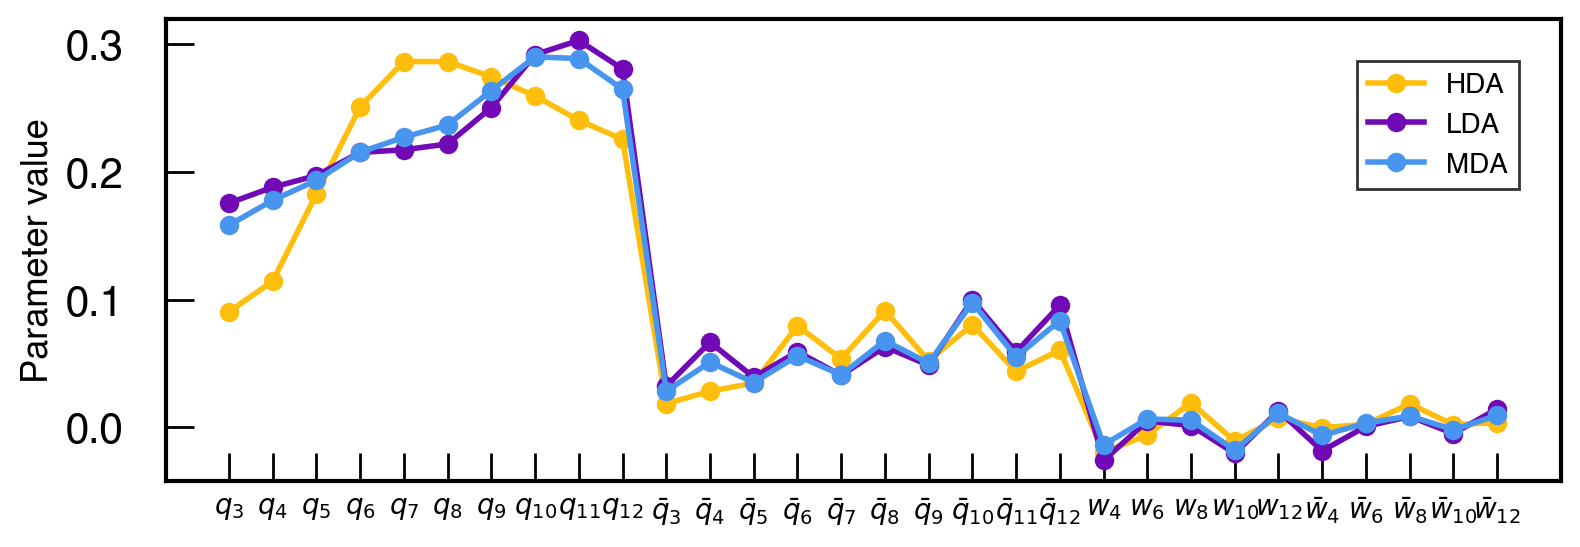

In [9]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('plot.mplstyle')
fig, ax = plt.subplots(1, 1, figsize=(9, 3),sharex=True)

mda_color = '#4895ef'

labels = ['HDA','LDA']
colors = ['#ffbe0b','#7209b7']

for i,(struct_type, steinhardts) in enumerate(fausto_av_steinhardt.items()):
    ax.plot(steinhardts,'-o',label=labels[i],color=colors[i],linewidth=2)

ax.plot(mda_av_steinhardt['mda'],'-o',label='MDA',color=mda_color,linewidth=2)
ax.legend(loc='upper right',fontsize=10)

ax.set_ylabel('Parameter value',fontsize=13)
ax.set_xticks(np.arange(0,30),list(desc_to_plot_label_mapping.values()),fontsize=10);

# reduce the gap between x-axis labels and x-axis
ax.tick_params(axis='x', which='major', pad=5)

# plt.savefig(f"../figures/steinhardt_individual_values/main_database.png",dpi=300,bbox_inches="tight")

In [10]:
from ase.io import read
traj_type = 'compression'

temp = 140
run = 1

if traj_type == 'compression':
    pressures =np.arange(100, 20_001, 100)
elif traj_type == 'decompression':
    pressures =np.arange(-5000, 19_901, 100)

traj_descriptors = {}
for p in pressures:
    file_name = f"../data/trajectories_{temp}K_run{run}/{traj_type}/{traj_type}_pressure{p}.extxyz"
    structures = read(file_name, index=':')
    # get an average steinhardt descriptor
    descriptors = []
    for s in structures:
        descriptors.append(s.arrays["steinhardt_descriptor"])
    
    
    # get a single descriptor for each atom in the whole trajectory (i.e. the average of all descriptors)
    av_atom_descriptor = np.mean(descriptors, axis=0) # shape = (512,30)
    
    # get a single descriptor for the whole structure
    av_structure_descriptor = np.mean(av_atom_descriptor, axis=0) # shape = (30,)
    
    traj_descriptors[p] = av_structure_descriptor

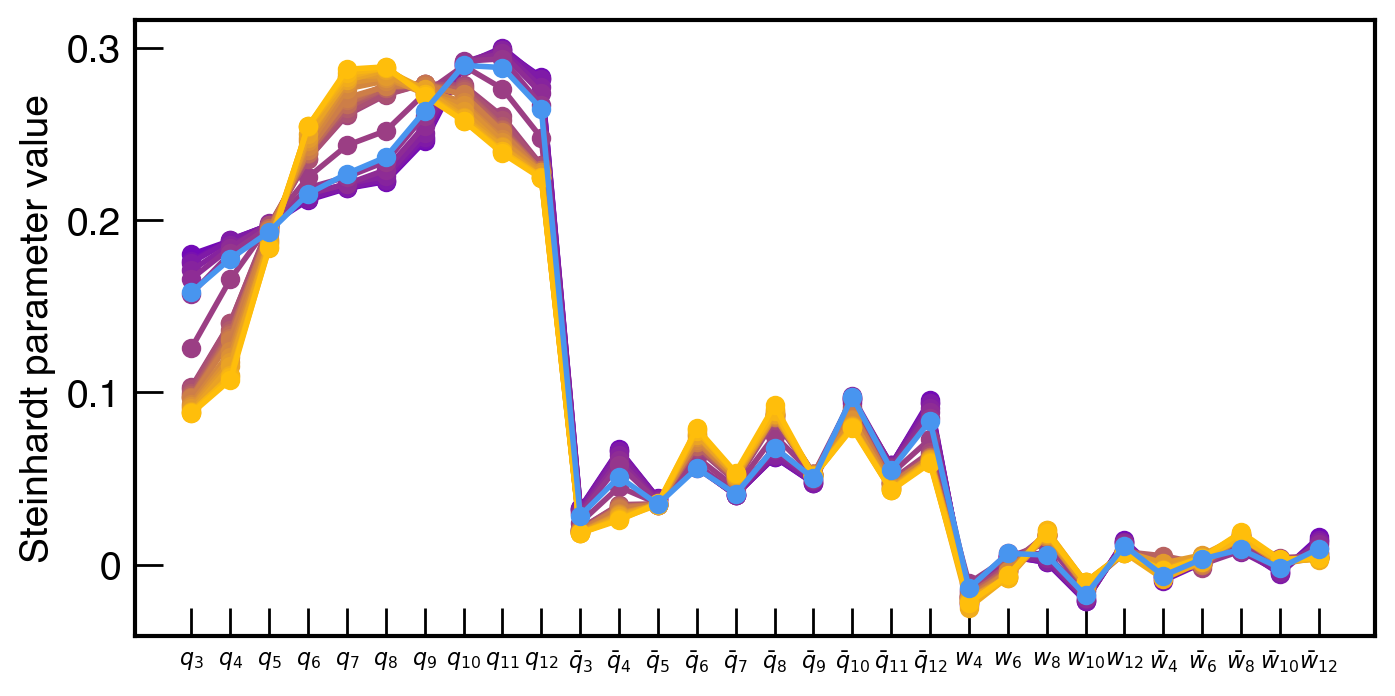

In [11]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('plot.mplstyle')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

mda_color = '#4895ef'
hda_color = '#ffbe0b'
lda_color = '#7209b7'
pressure_colours = list(colour_gradient(range(0,len(pressures)), lda_color, hda_color))

plotted_pressures = []
for i,(p, steinhardts) in enumerate(traj_descriptors.items()):
    # only plot every 10th pressure
    if p % 1000 == 0 or p == 100:
        plotted_pressures.append(p)
        ax.plot(steinhardts,'-o',label=p,color=pressure_colours[i][1],linewidth=2)

ax.plot(mda_av_steinhardt['mda'],'-o',label='MDA',color=mda_color,linewidth=2)
# ax.legend(title='Pressure',fontsize=10)
ax.set_ylabel('Steinhardt parameter value',fontsize=14)
ax.set_xticks(np.arange(0,30),list(desc_to_plot_label_mapping.values()),fontsize=8);
ax.set_yticks([0,0.1,0.2,0.3],[0,0.1,0.2,0.3],fontsize=14)

# reduce the gap between x-axis labels and x-axis
ax.tick_params(axis='x', which='major', pad=5)
ax.tick_params(axis='y', which='major', pad=5)
# rotate the x-axis labels


# add a colourbar based on pressure_colours
# from matplotlib import cm
# from matplotlib.colors import ListedColormap

# cmap = ListedColormap([pressure_colours[i][1] for i in range(len(pressures))])
# norm = plt.Normalize(min(pressures), max(pressures))
# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# cbar = fig.colorbar(sm, ticks=plotted_pressures[::2],ax=ax)
# cbar.ax.set_ylabel('Pressure',fontsize=14)
# # reduce the gap between colorbar and colorbar labels
# cbar.ax.tick_params(axis='y', which='major', pad=5,labelsize=10,size=0)

# plt.savefig(f"../figures/paper/trajectories_colorbar.svg",dpi=300,bbox_inches="tight")


In [17]:
# find the pressure at which the structure is most similar to the mda structure
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

mda_descriptor = mda_av_steinhardt['mda']

cosine_distances = []
pearson_correlations = []
rmse_distances = []
for p, descriptor in traj_descriptors.items():
    cosine_distances.append(cosine(mda_descriptor, descriptor))
    pearson_correlations.append(pearsonr(mda_descriptor.flatten(), descriptor.flatten())[0])
    rmse_distances.append(np.sqrt(np.mean((mda_descriptor - descriptor)**2)))
    
cosine_distances = np.array(cosine_distances)
pearson_correlations = np.array(pearson_correlations)
rmse_distances = np.array(rmse_distances)

# find the pressure at which the structure is most similar to the mda structure
min_cosine = np.min(cosine_distances)
min_cosine_p = pressures[np.argmin(cosine_distances)]
min_pearson = np.max(pearson_correlations)
min_pearson_p = pressures[np.argmax(pearson_correlations)]
min_rmse = np.min(rmse_distances)
min_rmse_p = pressures[np.argmin(rmse_distances)]

print(f"Minimum cosine distance = {min_cosine} at pressure = {min_cosine_p}")
print(f"Maximum Pearson correlation = {min_pearson} at pressure = {min_pearson_p}")
print(f"Minimum RMSE distance = {min_rmse} at pressure = {min_rmse_p}")

Minimum cosine distance = 0.00011286338860605483 at pressure = 5200
Maximum Pearson correlation = 0.9998023154679334 at pressure = 5200
Minimum RMSE distance = 0.0022321036676723194 at pressure = 5500
